# Import Modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.manifold import TSNE
import torch
from torch import nn
from torch import optim

from deep_occupancy_detection import models
import utils

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare Data

In [3]:
source_X = pd.read_csv("./deep_occupancy_detection/data/1_X_train.csv").values
target_X = pd.read_csv("./deep_occupancy_detection/data/2_X_train.csv").values
source_y_task = pd.read_csv("./deep_occupancy_detection/data/1_Y_train.csv").values.reshape(-1)
target_y_task = pd.read_csv("./deep_occupancy_detection/data/2_Y_train.csv").values.reshape(-1)

scaler = preprocessing.StandardScaler()
scaler.fit(source_X)
source_X = scaler.transform(source_X)
target_X = scaler.transform(target_X)

In [4]:
source_loader, target_loader, source_y_task, source_X, target_X, target_y_task = utils.get_loader(source_X, target_X, source_y_task, target_y_task, batch_size=80)

# Instantiate Feature Extractor, Domain Classifier, Task Classifier

In [5]:
hidden_size = 10
num_domains = 1
num_classes = 1
dropout_ratio = 0.5

feature_extractor = utils.Encoder(input_size=source_X.shape[1], output_size=hidden_size).to(device)
domain_classifier = utils.Decoder(input_size=hidden_size, output_size=num_domains).to(device)
task_classifier = models.AttentionRNN(input_size=hidden_size, hidden_size=hidden_size,
                                      num_layers=1, num_classes=num_classes).to(device)

In [6]:
learning_rate = 0.001

criterion = nn.BCELoss()
feature_optimizer = optim.Adam(feature_extractor.parameters(), lr=learning_rate)
domain_optimizer = optim.Adam(domain_classifier.parameters(), lr=learning_rate)
task_optimizer = optim.Adam(task_classifier.parameters(), lr=learning_rate, weight_decay=0.01)

# Domain Invariant Learning

In [7]:
num_epochs = 200

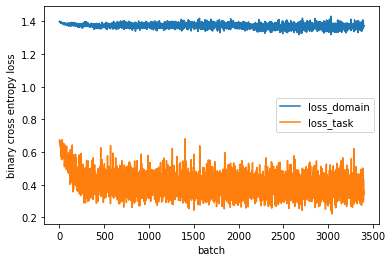

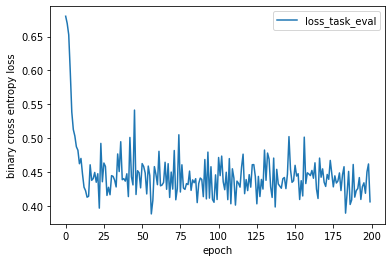

In [8]:
feature_extractor, task_classifier = utils.fit(source_loader, target_loader, target_X, target_y_task,
                                               feature_extractor, domain_classifier, task_classifier, criterion,
                                               feature_optimizer, domain_optimizer, task_optimizer, num_epochs=num_epochs, is_timeseries=True)

# Domain Adaptation Accuracy

In [10]:
target_feature_eval = feature_extractor(target_X)

n_days = target_feature_eval.shape[0]//16
target_feature_eval = target_feature_eval.reshape(n_days, 16, target_feature_eval.shape[1])

pred_y_task = task_classifier(target_feature_eval, device)
pred_y_task = torch.sigmoid(pred_y_task).reshape(-1)
pred_y_task = pred_y_task > 0.5

acc = sum(pred_y_task == target_y_task) / target_y_task.shape[0]
print(f"Accuracy:{acc}")

Accuracy:0.8265305757522583


# Without Adaptation

In [23]:
task_classifier = utils.Decoder(input_size=source_X.shape[1], output_size=num_classes).to(device)
task_optimizer = optim.Adam(task_classifier.parameters(), lr=learning_rate)

In [24]:
task_classifier = utils.fit_without_adaptation(source_loader, task_classifier, task_optimizer, criterion, num_epochs)

In [25]:
pred_y_task = task_classifier(target_X)
pred_y_task = torch.sigmoid(pred_y_task).reshape(-1)
pred_y_task = pred_y_task > 0.5
acc = sum(pred_y_task == target_y_task) / target_y_task.shape[0]
print(f"Without Adaptation Accuracy:{acc}")

Without Adaptation Accuracy:0.8207908272743225


# t-SNE Visualization for Extracted Feature

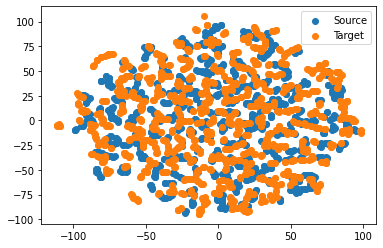

In [26]:
# TODO: Absorb function specification changes
utils.visualize_tSNE(target_feature_eval, source_X, feature_extractor)